# Praca inżynierska
Marcin Bobiński
nr albumu: 297225

In [1]:
import os
HOME_PATH = os.getcwd()
RESEARCH_PATH = os.path.join(HOME_PATH, "models/research")
DATASET_PATH = os.path.join(HOME_PATH, "Dataset")
PRETRAINED_MODELS_PATH = os.path.join(HOME_PATH, "pretrained_models")
DATA_PATH = os.path.join(HOME_PATH, "data")
TF_RECORD_PATH = os.path.join(DATA_PATH, "tf_record")
MY_MODEL = os.path.join(HOME_PATH, "my_model")

# Uczenie modelu
## Przygotowanie plików tf record

Config

In [22]:
import os
import shutil

os.chdir(HOME_PATH)
if not os.path.exists(MY_MODEL):
    os.makedirs(MY_MODEL)

_ = shutil.copy(
    os.path.join(PRETRAINED_MODELS_PATH,"ssd640","pipeline.config"),
    MY_MODEL
)

Uczenie

In [4]:
training = f"python object_detection/model_main_tf2.py \
--pipeline_config_path={os.path.join(MY_MODEL,'pipeline.config')} \
--model_dir={os.path.join(MY_MODEL,'checkpoints')} \
--alsologtostderr"
print(training)

python object_detection/model_main_tf2.py --pipeline_config_path=D:\DEV\GeoTree\TreeDetection\my_model\pipeline.config --model_dir=D:\DEV\GeoTree\TreeDetection\my_model\checkpoints --alsologtostderr


In [21]:
tensorboard = f"tensorboard --logdir={os.path.join(MY_MODEL,'checkpoints')}"
print(tensorboard)

tensorboard --logdir=D:\DEV\GeoTree\TreeDetection\my_model\checkpoints


Export the inference graph

In [2]:
os.chdir(RESEARCH_PATH)

os.system(f"python object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path {os.path.join(MY_MODEL,'pipeline.config')} \
    --trained_checkpoint_dir {os.path.join(MY_MODEL,'checkpoints')} \
    --output_directory {os.path.join(MY_MODEL, 'inference_graph')}")

0

Export TF Lite graph

In [9]:
os.chdir(RESEARCH_PATH)

os.system(f"python object_detection/export_tflite_graph_tf2.py \
    --pipeline_config_path {os.path.join(MY_MODEL,'pipeline.config')} \
    --trained_checkpoint_dir {os.path.join(MY_MODEL,'checkpoints')} \
    --output_directory {os.path.join(MY_MODEL, 'inference_tflite_graph')} \
    --max_detections 100 \
    --ssd_use_regular_nms True"
)

os.chdir(HOME_PATH)

In [10]:
import tensorflow as tf

os.chdir(os.path.join(MY_MODEL, 'inference_tflite_graph'))

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join(MY_MODEL, 'inference_tflite_graph', 'saved_model')) # path to the SavedModel directory

converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
# converter.optimizations = [ tf.lite.Optimize.EXPERIMENTAL_SPARSITY ]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
# converter.inference_input_type = [tf.int8]

converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

os.chdir(HOME_PATH)

Mask-RCNN

In [8]:
import tensorflow as tf
model = tf.saved_model.load(os.path.join(MY_MODEL,"inference_graph","saved_model"))

os.chdir(os.path.join(MY_MODEL, 'inference_tflite_graph'))

keras_model = model.keras_model
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

converter.optimizations = [ tf.lite.Optimize.DEFAULT ]

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

os.chdir(HOME_PATH)

AttributeError: '_UserObject' object has no attribute 'keras_model'

In [4]:
import tensorflow as tf

os.chdir(os.path.join(MY_MODEL, 'inference_tflite_graph'))

converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join(MY_MODEL,"inference_graph","saved_model"))
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
converter.optimizations = [ tf.lite.Optimize.OPTIMIZE_FOR_SIZE ]
# converter.optimizations = [ tf.lite.Optimize.EXPERIMENTAL_SPARSITY ]

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

os.chdir(HOME_PATH)

Testing

In [11]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path=os.path.join(MY_MODEL, "inference_tflite_graph","model.tflite"), num_threads=6)
interpreter.allocate_tensors()

# Print input shape and type
print(interpreter.get_input_details()[0]['shape'], interpreter.get_input_details()[0]['dtype'])
# Print output shape and type
for i in range(4):
    print(interpreter.get_output_details()[i]['shape'], interpreter.get_output_details()[i]['dtype'])

[  1 640 640   3] <class 'numpy.float32'>
[  1 100] <class 'numpy.float32'>
[  1 100   4] <class 'numpy.float32'>
[1] <class 'numpy.float32'>
[  1 100] <class 'numpy.float32'>


In [12]:
import cv2

import timeit
import time

from PIL import Image
from IPython.display import display

import numpy as np

from models.research.object_detection.utils import label_map_util
from models.research.object_detection.utils import visualization_utils as vis_util

category_index = label_map_util.create_category_index_from_labelmap(os.path.join(DATA_PATH, "annotations.pbtxt"), use_display_name=True)

input_index = interpreter.get_input_details()[0]["index"]
scores_index = interpreter.get_output_details()[0]['index']
boxes_index = interpreter.get_output_details()[1]['index']
detection_num_index = interpreter.get_output_details()[2]['index']
classes_index = interpreter.get_output_details()[3]['index']

np.set_printoptions(suppress=True, precision=3)

def run_inference_and_display(image_path):
    image_np = np.array(Image.open(image_path))
    # image_np = cv2.imread(image_path)
    image_np = cv2.resize(image_np,(640,640))

    input_tensor = np.array(np.expand_dims(image_np,0), dtype=np.float32)
    # input_tensor = np.array(np.expand_dims(image_np,0), dtype=np.uint8)

    interpreter.set_tensor(input_index, input_tensor)

    t = time.time()
    interpreter.invoke()
    t = time.time() - t

    scores = np.squeeze(interpreter.get_tensor(scores_index))
    boxes = np.squeeze(interpreter.get_tensor(boxes_index))
    classes = np.squeeze(interpreter.get_tensor(classes_index)).astype(np.int64) + 1

    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        boxes,
        classes,
        scores,
        category_index,
        min_score_thresh=.1,
        use_normalized_coordinates=True,
        line_thickness=4)

    display(Image.fromarray(image_np))
    print("inference time:", round(t*1000), "ms")
    print("Scores:", scores * 100)
    print("Scores:", scores.sum() )

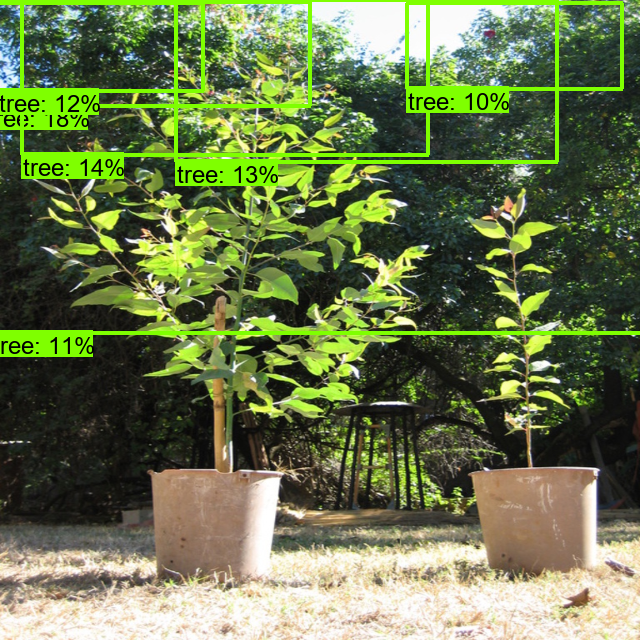

inference time: 7780 ms
Scores: [18.05  14.184 13.124 11.864 10.964 10.179  9.603  9.146  8.59   7.847
  6.699  6.508  6.479  6.232  6.118  6.049  5.847  5.526  5.236  5.138
  4.892  4.723  4.519  4.397  4.301  4.254  4.177  4.158  4.153  4.133
  4.013  4.01   3.95   3.911  3.841  3.766  3.762  3.739  3.656  3.584
  3.556  3.532  3.488  3.485  3.463  3.452  3.393  3.365  3.358  3.347
  3.332  3.279  3.275  3.25   3.247  3.165  3.157  3.149  3.149  3.105
  3.098  3.096  3.092  3.046  3.032  3.031  2.99   2.985  2.947  2.944
  2.914  2.904  2.889  2.887  2.874  2.863  2.86   2.838  2.833  2.812
  2.8    2.793  2.786  2.779  2.774  2.771  2.758  2.753  2.749  2.734
  2.718  2.718  2.716  2.708  2.699  2.695  2.679  2.668  2.667  2.666]
Scores: 4.354337


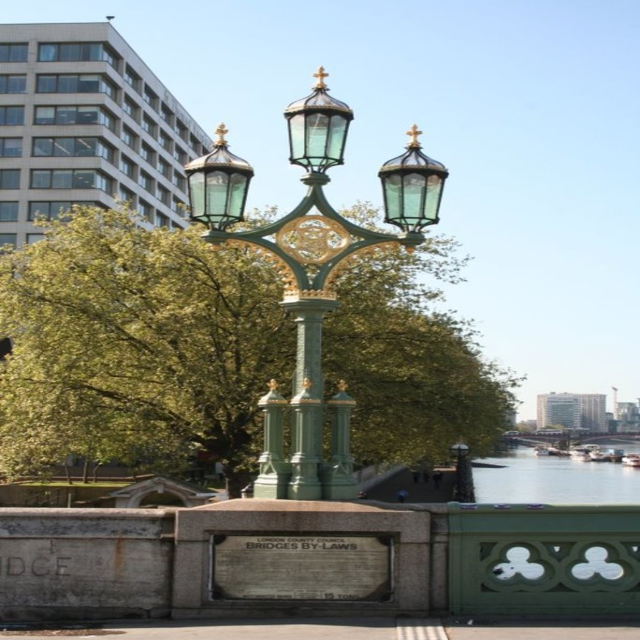

inference time: 7385 ms
Scores: [9.167 7.63  6.067 5.709 5.672 5.509 5.476 5.284 4.834 4.665 4.63  4.617
 4.558 4.453 4.438 4.313 4.102 4.089 3.936 3.935 3.903 3.888 3.875 3.819
 3.722 3.714 3.663 3.64  3.624 3.583 3.582 3.58  3.556 3.483 3.474 3.445
 3.421 3.401 3.306 3.215 3.206 3.189 3.177 3.169 3.149 3.094 3.085 3.077
 3.05  3.014 3.011 2.999 2.981 2.973 2.942 2.928 2.927 2.907 2.901 2.891
 2.837 2.828 2.792 2.786 2.782 2.78  2.769 2.763 2.741 2.735 2.732 2.729
 2.72  2.713 2.708 2.672 2.668 2.653 2.644 2.638 2.627 2.625 2.617 2.615
 2.611 2.606 2.595 2.595 2.594 2.585 2.584 2.57  2.569 2.567 2.561 2.557
 2.532 2.527 2.523 2.522]
Scores: 3.4192195


In [13]:
EXAMPLE_IMAGES_DATA_PATH = os.path.join(HOME_PATH, "example_images")
images = list(filter(lambda x: str(x).endswith(".jpg"),os.listdir(EXAMPLE_IMAGES_DATA_PATH)))
for image in images:
    run_inference_and_display(os.path.join(EXAMPLE_IMAGES_DATA_PATH, image))
    pass

In [7]:
import numpy as np
import os
import tensorflow as tf

from PIL import Image
from IPython.display import display

from models.research.object_detection.utils import ops as utils_ops
from models.research.object_detection.utils import label_map_util
from models.research.object_detection.utils import visualization_utils as vis_util


utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

model = tf.saved_model.load(os.path.join(MY_MODEL,"inference_graph","saved_model"))
category_index = label_map_util.create_category_index_from_labelmap(os.path.join(DATA_PATH, "annotations.pbtxt"), use_display_name=True)

def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    need_detection_key = ['detection_classes','detection_boxes','detection_masks','detection_scores']
    output_dict = {key: output_dict[key][0, :num_detections].numpy()
               for key in need_detection_key}
    output_dict['num_detections'] = num_detections
    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            tf.convert_to_tensor(output_dict['detection_masks']), output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    return output_dict

def show_inference(model, image_path):
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=4)

    display(Image.fromarray(image_np))

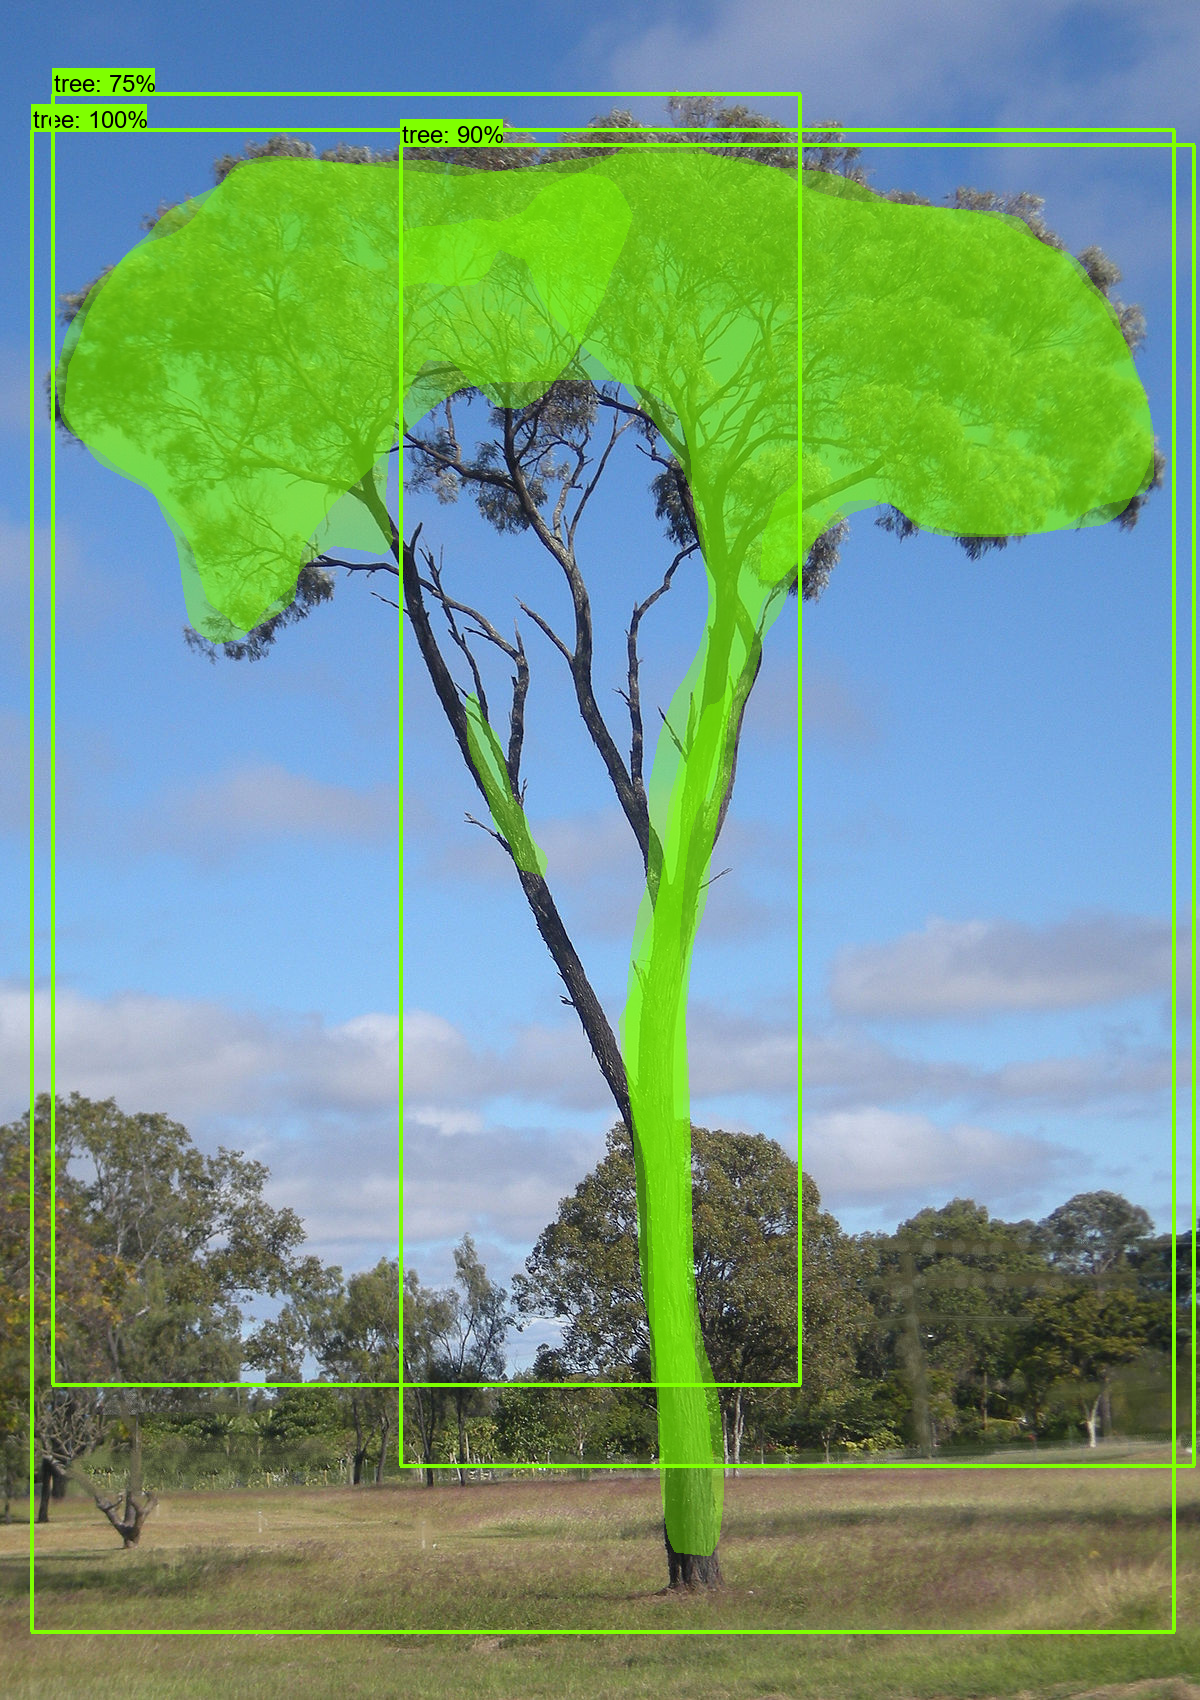

In [9]:

EXAMPLE_IMAGES_DATA_PATH = os.path.join(HOME_PATH, "example_images")
images = list(filter(lambda x: str(x).endswith(".jpg"),os.listdir(EXAMPLE_IMAGES_DATA_PATH)))
for image in images:
   show_inference(model, os.path.join(EXAMPLE_IMAGES_DATA_PATH, image))
   break